## ref : https://www.kaggle.com/ngyptr/multi-class-classification-with-lstm

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


def show_table(df):
    print('>>> shape :', df.shape)
    print('>>> number of NA :', df.isna().sum().sum())
    display(df.head(3))
    display(df.tail(3))

/kaggle/input/news-aggregator-dataset/uci-news-aggregator.csv


In [2]:
data = pd.read_csv('../input/news-aggregator-dataset/uci-news-aggregator.csv', usecols=['TITLE', 'CATEGORY'])
show_table(data)

>>> shape : (422419, 2)
>>> number of NA : 0


,TITLE,CATEGORY
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b


,TITLE,CATEGORY
422416,Child who swallowed battery to have reconstruc...,m
422417,Phoenix boy undergoes surgery to repair throat...,m
422418,Phoenix boy undergoes surgery to repair throat...,m


## EDA

- CATEGORY : the category of the news item; one of:
  - b : business
  - t : science and technology
  - e : entertainment
  - m : health

,e,b,t,m
CATEGORY,152469,115967,108344,45639


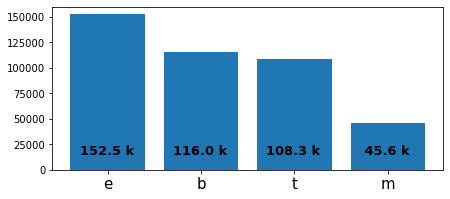

In [3]:
# Distribution of Category
count_ser = data.CATEGORY.value_counts()

display(count_ser.to_frame().T)

plt.figure(figsize=(7, 3))
plt.bar(count_ser.index, count_ser, color='tab:blue')
plt.xticks(size=15)
for idx, (cat, count) in enumerate(zip(count_ser.index, count_ser)):
    plt.text(idx-0.3, 15000, s=f'{count/1000:^6.1f}k', size=13, color='k', weight='bold')
plt.show()

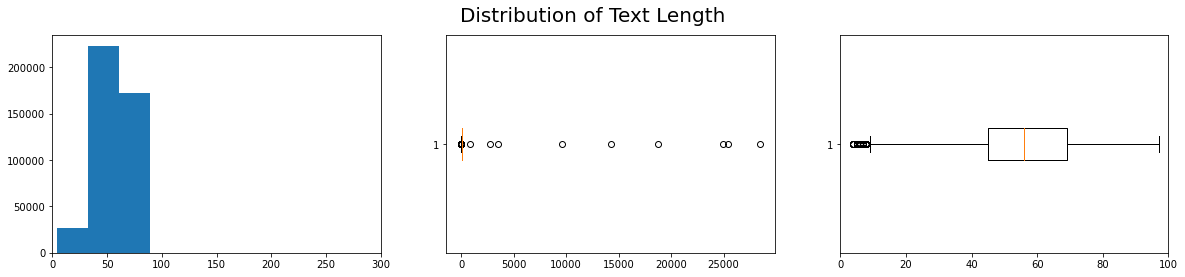

In [4]:
# Distribution of text length
data['TITLE_len'] = data.TITLE.apply(len)

fig, ax = plt.subplots(1, 3, figsize=(20, 4))
ax[0].hist(data.TITLE_len, bins=1000)
ax[0].set_xlim(0, 300)
ax[1].boxplot(data.TITLE_len, vert=False)
ax[2].boxplot(data.TITLE_len, vert=False)
ax[2].set_xlim(0, 100)
plt.suptitle('Distribution of Text Length', size=20)
plt.show()

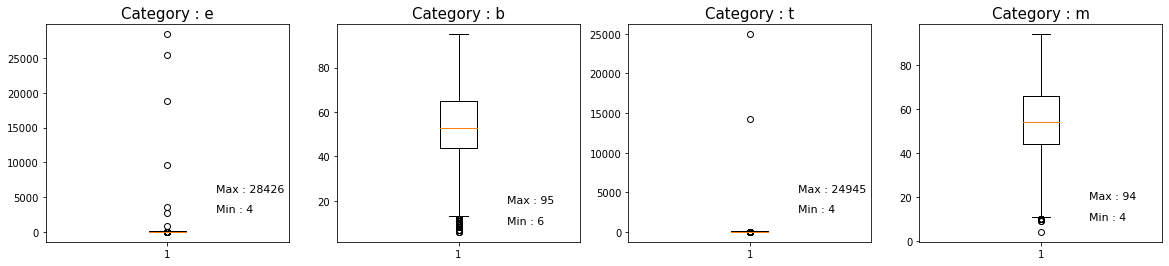

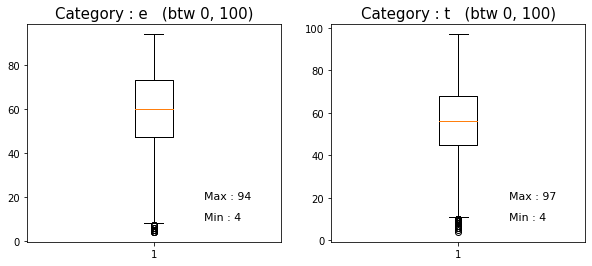

In [5]:
# Distribution of text length by Category
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
for idx, cat in enumerate(count_ser.index):
    tmp_df = data[data.CATEGORY==cat]
    
    ax[idx].boxplot(data[data.CATEGORY==cat].TITLE_len)
    ax[idx].set_title(f'Category : {cat}', size=15)
    
    max_val, min_val = tmp_df.TITLE_len.max(), tmp_df.TITLE_len.min()
    ax[idx].text(1.2, max_val*0.2, s=f'Max : {max_val}', size=11)
    ax[idx].text(1.2, max_val*0.1, s=f'Min : {min_val}', size=11)


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for idx, cat in enumerate(['e', 't']):
    tmp_df = data[(data.CATEGORY==cat) & (data.TITLE_len<100)]
    
    ax[idx].boxplot(tmp_df.TITLE_len)
    ax[idx].set_title(f'Category : {cat}   (btw 0, 100)', size=15)
    
    max_val, min_val = tmp_df.TITLE_len.max(), tmp_df.TITLE_len.min()
    ax[idx].text(1.2, max_val*0.2, s=f'Max : {max_val}', size=11)
    ax[idx].text(1.2, max_val*0.1, s=f'Min : {min_val}', size=11)

In [6]:
# Check outliers - too long TITLE_len
outlier_df = data[data.TITLE_len>100].sort_values('TITLE_len').reset_index(drop=True)

## remove URL from title
outlier_df['TITLE_new'] = outlier_df['TITLE'].apply(lambda x : x.split('\thttp')[0])
outlier_df['TITLE_len_new'] = outlier_df['TITLE_new'].apply(len)
display(outlier_df)

,TITLE,CATEGORY,TITLE_len,TITLE_new,TITLE_len_new
0,I don't know why I'm a sex symbol' says smould...,e,824,I don't know why I'm a sex symbol' says smould...,78
1,The Best Reactions To The Supposed Video of So...,e,2779,The Best Reactions To The Supposed Video of So...,72
2,The Fault In Our Stars' to release in India on...,e,3528,The Fault In Our Stars' to release in India on...,53
3,Hunger Games' top winner at MTV Movie Awards\t...,e,9590,Hunger Games' top winner at MTV Movie Awards,44
4,"More Japanese Xbox One Games In Development, A...",t,14260,"More Japanese Xbox One Games In Development, A...",74
5,Love & Hip-Hop' Star Benzino Shot By Nephew En...,e,18758,Love & Hip-Hop' Star Benzino Shot By Nephew En...,72
6,"A few years ago, scientists calculated that be...",t,24945,"A few years ago, scientists calculated that be...",86
7,I never thought I'd be in love” says Angelina ...,e,25422,I never thought I'd be in love” says Angelina ...,51
8,Peaches has died. We are beyond pain.\thttp://...,e,28426,Peaches has died. We are beyond pain.,37


In [7]:
# Check outliers - TITLE with only URL
outlier_df = data[data.TITLE.str.startswith('http://')].reset_index(drop=True)

## extract content-related keywords from URL
outlier_df['TITLE_new'] = outlier_df['TITLE'].apply(lambda x : x.split('//')[-1].split('.')[0] + '-' + x.split('//')[-1].split('.')[1] + '-'  + x.split('/')[-1])
outlier_df['TITLE_len_new'] = outlier_df['TITLE_new'].apply(len)
display(outlier_df)

,TITLE,CATEGORY,TITLE_len,TITLE_new,TITLE_len_new
0,http://pediatrics.about.com/b/2014/03/27/respo...,m,83,pediatrics-about-responses-to-the-latest-cdc-r...,59
1,http://surgery.about.com/b/2014/03/30/too-sick...,m,85,surgery-about-too-sick-for-aortic-valve-stenos...,61
2,http://mutualfunds.about.com/b/2014/03/31/the-...,b,80,mutualfunds-about-the-stock-market-rigged-what...,56
3,http://movies.about.com/b/2014/04/11/review-ro...,e,82,movies-about-review-round-up-for-the-weekend-o...,58
4,http://mustangs.about.com/b/2014/04/15/its-off...,t,87,mustangs-about-its-official-ford-to-offer-50th...,63
5,http://ent.about.com/b/2014/05/20/study-finds-...,m,81,ent-about-study-finds-increased-incidence-of-h...,57
6,http://www.womenhiv.org,m,23,www-womenhiv-www.womenhiv.org,29
7,http://brooklyn.about.com/od/July-4-Independen...,e,80,brooklyn-about-Can-You-Watch-Macys ...,39
8,http://movies.about.com/od/Blog/tp/Comic-Con-2...,e,77,movies-about-Comic-Con-2014-The-Five-Biggest-M...,55


## Data Preprocessing 1. Handling Outliers

>>> shape : (422419, 3)
>>> number of NA : 0


,TITLE,CATEGORY,TITLE_len
0,"Fed official says weak data caused by weather,...",b,68
1,Fed's Charles Plosser sees high bar for change...,b,66
2,US open: Stocks fall after Fed official hints ...,b,69


,TITLE,CATEGORY,TITLE_len
422416,Child who swallowed battery to have reconstruc...,m,77
422417,Phoenix boy undergoes surgery to repair throat...,m,74
422418,Phoenix boy undergoes surgery to repair throat...,m,78


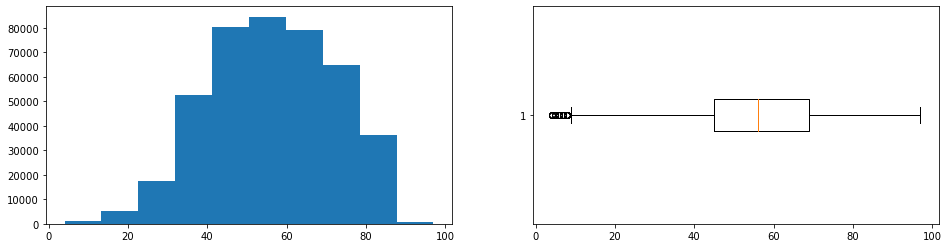

In [8]:
# Handling Outliers
data.loc[data.TITLE_len>100, 'TITLE'] = data.loc[data.TITLE_len>100, 'TITLE'].apply(lambda x : x.split('\thttp')[0])
data.loc[data.TITLE.str.startswith('http://'), 'TITLE'] = data.loc[data.TITLE.str.startswith('http://'), 'TITLE'].apply(lambda x : x.split('//')[-1].split('.')[0] + '-' + x.split('//')[-1].split('.')[1] + '-'  + x.split('/')[-1])
data['TITLE_len'] = data['TITLE'].apply(len)


# Check result
show_table(data)

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].hist(data.TITLE_len)
ax[1].boxplot(data.TITLE_len, vert=False)
plt.show()

## Data Preprocessing 2. Balance the Dataset in regard of Category
- Applied down-sampling

In [9]:
sample_num = 45000
data_shuffled = data.reindex(np.random.permutation(data.index))
train_df = pd.concat([data_shuffled[data_shuffled['CATEGORY']==cat][:sample_num] for cat in data_shuffled.CATEGORY.unique()],
                     ignore_index=True)
train_df = train_df.reindex(np.random.permutation(train_df.index))


# Check the result
show_table(train_df)
display(train_df.CATEGORY.value_counts().to_frame().T)

>>> shape : (180000, 3)
>>> number of NA : 0


,TITLE,CATEGORY,TITLE_len
177842,Indiana Corn Planted up 11 Percent Despite Lim...,b,61
83362,Wu-Tang Affiliated Rapper Cuts Off Private Par...,e,68
54727,Harrison Ford Has Been Injured By The Millenni...,e,55


,TITLE,CATEGORY,TITLE_len
29915,The Andromeda Strain - Scientist who discovere...,m,76
79423,Kanye West - Kanye West gives Kim Kardashian p...,e,53
103832,iPhone 6 sapphire display crystal display: unb...,t,65


,m,e,t,b
CATEGORY,45000,45000,45000,45000


## Data Preprocessing 3. Encoding the Target Feature (Category)
- applied one-hot encoding

In [10]:
# Label Encoding
lb_enc = LabelEncoder()
label_arr = lb_enc.fit_transform(train_df['CATEGORY'])
print(label_arr[:5], '\n')

# One-hot Encoding
one_hot_arr = to_categorical(label_arr, num_classes=4)
print(one_hot_arr[:5])

[0 1 1 0 0] 

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
